# PHYS 441/DATA SCI 421 FINAL

## Milky Way morphology probed by 6D astrometric data from the Gaia space telescope

---

By Josh Harry  
06 December 2022

### Instructions

This template for the final project is written as a Jupyter Notebook, which allows for a nice mix of standard text as well as software and plotting. 

Text in a Jupyter notebook is written using Markdown. The formatting is fairly straightforward, with many tutorials online ([this one is fairly comprehensive](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd)). 

Follow this template when completing the final project.

## Introduction

*Write a single paragraph providing context for the project. What measurement/analysis is going to be attempted and why is this important in the field in question.*<br><br>
At varying height above and below the plane of the Milky Way, I have used astrometric methods to classify stars of different galactic components of the Milky Way – the thin disk, thick disk, and stellar halo. This project complements prior study of Milky Way sub–structure – notably involving number density and/or pairwise correlations – which demonstrate non–steady state effects in the galaxy, such as axial/north–south symmetry breaking [1,2] or more complex phenomena in Milky Way phase space like the Gaia snail [3]. This has motivated an exploration of stellar population changes with height about the Milky Way mid–plane, and the study of symmetry in such changes above and below the galactic mid–plane. This can be done solely with 6D astrometric information for each star (angular positions, parallax, proper motions, and radial velocity). For my Master's thesis in Spring 2022, I carried out such an analysis on a set of Gaia Data Release 2 (DR2) data and formalized the results. But in June 2022, Gaia's third data release (DR3) was made public, greatly expanding the sample of stars with non-trivial radial velocity data, as well as improving astrometric uncertainties. For reference, DR2 yielded a working sample of 695,345 stars (after appropriate selection cuts), compared to 3,168,467 in DR3. For this final project, I am repeating my Master's thesis analysis on a new DR3 data set, with a couple of procedural differences.<br>
1. S. Gardner, A. Hinkel, and B. Yanny, “Applying Noether’s Theorem to Matter
in the Milky Way: Evidence for External Perturbations and Non-steady-state
Effects from Gaia Data Release 2,” The Astrophysical Journal, vol. 890, p. 110,
February 2020.<br>
2. L. M. Widrow, S. Gardner, B. Yanny, S. Dodelson, and H.-Y. Chen, “Galacto-
seismology: Discovery of Vertical Waves in the Galactic Disk,” ApJL, vol. 750,
p. L41, May 2012.<br>
3. T. Antoja, A. Helmi, M. Romero-G ́omez, D. Katz, et al., “A dynamically young
and perturbed Milky Way disk,” Nature, vol. 561, pp. 360–362, September 2018.

## Data

*Introduce the data by describing the measurements, how they were collected, and how you managed to curate them for this project. In many cases it will also be appropriate to show a figure of the data.*<br><br>
The online Gaia archive is accessible via query -- either directly from the archive website (https://gea.esac.esa.int/archive/) or through code packages (e.g. *astroquery* in Python). The online archive is my personal preference, as the GUI keeps a record of past queries for later reference. Gaia queries are written in the Astronomical Data Query Language (ADQL), a variant of SQL specialized to astronomical datasets.<br><br>
For this project, I provide the .csv file for my queried data, which is loaded into Python in a code snippet below. Make sure the file is in the same directory as this notebook.

### Query
Below I have given the full Gaia query for my stellar sample:<br><br>
“SELECT <span style="color:red">1/gaia_source.parallax AS d, gaia_source.l, gaia_source.b, gaia_source.ra, gaia_source.dec, gaia_source.ra_error, gaia_source.dec_error, gaia_source.parallax_error, gaia_source.pmra_error, gaia_source.pmdec_error, gaia_source.radial_velocity_error, gaia_source.phot_g_mean_mag as G, gaia_source.radial_velocity, gaia_source.pmra, gaia_source.pmdec, gaia_source.bp_rp, gaia_source.phot_g_mean_mag+5\*log10(gaia_source.parallax)-10 as mg </span> FROM <span style="color:green">gaiadr3.gaia_source</span> WHERE <span style="color:blue">(gaia_source.radial_velocity IS NOT NULL AND ABS(gaia_source.b) > 30 AND gaia_source.phot_g_mean_mag > 10 AND gaia_source.phot_g_mean_mag < 18 AND gaia_source.bp_rp < 2.5 AND gaia_source.bp_rp > 0.5 AND ABS((1/gaia_source.parallax)\*SIN(RADIANS(gaia_source.b))) < 3.0 AND ABS((1/gaia_source.parallax)\*SIN(RADIANS(gaia_source.b))) > 0.2 AND (1/gaia_source.parallax)\*COS(RADIANS(gaia_source.b)) < 1.2 AND gaia_source.parallax > 0 AND gaia_source.astrometric_params_solved = 31)</span>”<br><br>
The important pieces are color coded as such:<br><br>
    **Red** - The parameters that we want to sample, for each star.<br>
    **Green** - Source of the data, DR3 in this case.<br>
    **Blue** - Various selections on the data to refine the returned sample (generally ordered from broadest to most specific). 

In [31]:
### These are for installing the necessary packages -- in case you don't have them! Only uncomment the ones you don't have and pip will install them to your Python installation for this Jupyter notebook

# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install matplotlib.pyplot
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install random

###

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import random

data = pd.read_csv('DR3_Query_G10_18.csv', sep = ',', header = 0)

### Query Selection Cuts
Prior work has been done in deducing selection criteria for a Gaia DR2 query, so
as to simultaneously minimize parallax errors and sampling biases, such as Gaia’s
scanning pattern of the sky [4]. The majority of the photometric/astrometric cuts here are motivated by such prior work, however, an important distinction for this study is that stars of nontrivial radial velocity are selected for.<br><br>
Gaia makes observations using three passbands/filters -- blue (330-680 nm), red (630-1050 nm), and green (330-1050 nm). Below is a figure of Gaia's transmissivity in the different passbands:<br>
<div>
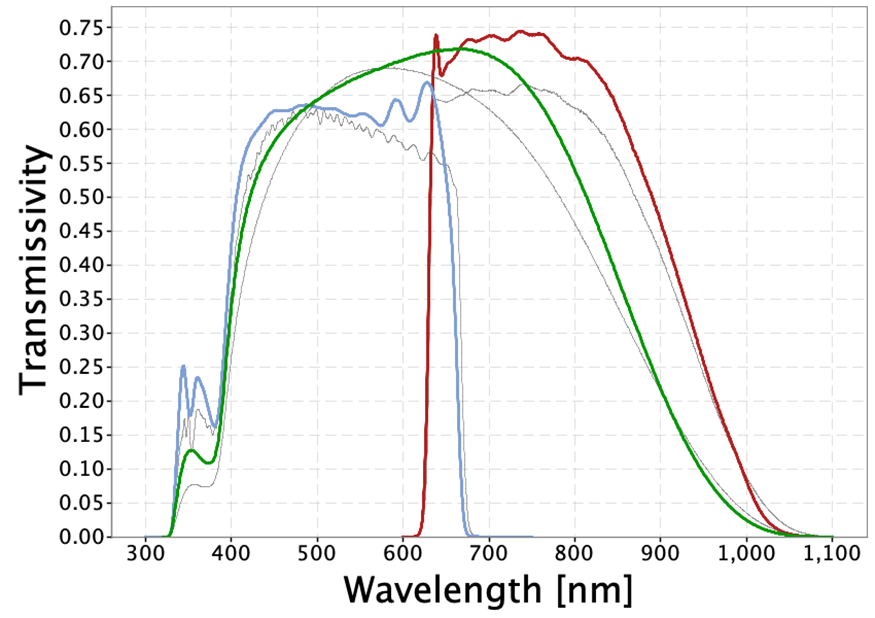
</div>
Passband transmissivity as a function of wavelength for the filters used in Gaia DR3 (Credits: ESA/Gaia/DPAC, P. Montegriffo, F. De Angeli, M. Bellazzini, E. Pancino, C. Cacciari, D. W. Evans, and CU5/PhotPipe team.)
<br><br>
For each star, Gaia calculates mean flux/magnitude values by integrating over the wavelength bands, yielding the average values $G_{BP}$ , $G_{RP}$ , and $G$ respective to the 3 bands. As in the ADQL query, we are only interested in stars with $10<G<18$ and $0.5<G_{BP}-G_{RP}<2.5$. The $G$-band lower limit is somewhat flexible, since Gaia only encounters completeness issues for bright stars past about $G<7$ [5].<br><br>
A quick note about sample completeness -- does selecting stars with radial velocities represent a complete sample we can make justified conclusions about? Well, Gaia calculates radial velocity using the Ca II triplet in the 845–872 nm range [6], which is well within the red passband. Thus, the completeness of our radial velocity sample is compatible with the (red passband) photometric completeness of samples in prior works.
<br><br>
Lastly, for the astrometric cuts. We are interested in stars at $b>30^\circ$ to avoid dust obscuration of the Milky Way mid-plane. We also want to restrict our in-plane distance to $d<1.2$ kpc from the Earth, and to a galactocentric height of $0.2<|z|<3.0$ kpc. The astrometric_params_solved flag tells Gaia to pick stars with non-nan values for the astrometry.
<br>

4. A. Hinkel, “Axial Symmetry Tests of Milky Way Disk Stars Probe the Galaxy’s
Matter Distribution,” Theses and Dissertations–Physics and Astronomy, vol. 89,
2021
5. Gaia Collaboration, A. Vallenari, A.G.A. Brown, T. Prusti, et al., “Gaia Data
Release 2. Summary of the contents and survey properties,” A&A, vol. 616,
p. A1, 2018.
6. https://blogs.esa.int/gaia/2014/06/27/commissioning-the-radial-velocity-spectrometer/


### Further Selections
Some selections on our sample are hard to implement in ADQL syntax and/or increase query time significantly. There are 3 important steps to consider:<br>
(1) Galactocentric radius, select stars with $7<R<9$ kpc (note $R=\sqrt{x^2+y^2+z^2}$)<br>
(2) Galactocentric polar angle, select stars with $174<\phi<186^\circ$ (note $\phi=\tan^{-1}\left(\frac{y}{x}\right)$)<br>
(3) “Box cuts” aka Magellanic Cloud excisions,<br>
LMC: Remove stars with $\left(30<|b|<39^\circ\right)\wedge\left(\left(271<\ell<287^\circ\right)\vee\left(73<\ell<89^\circ\right)\right)$<br>
SMC: Remove stars with $\left(41<|b|<48^\circ\right)\wedge\left(\left(299<\ell<307^\circ\right)\vee\left(53<\ell<61^\circ\right)\right)$

In [20]:
# Here is the implementation of the non-ADQL selections

# For rendering plot text in LaTeX font & adjusting font size
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.size"] = "16"

global R0
R0 = 8.178 # distance of the Sun from the galactic center, in kpc

def selection_cuts(dataset):
    
    numstars = len(dataset)
    
    dataset = np.array(dataset[['d','l','b','ra','dec','radial_velocity','pmra','pmdec']])
    
    copy = np.array(dataset, copy=True)
    indices = np.array([], dtype = np.uint32)

    for i in range(numstars):
        flag = False
        x = dataset[i][0]*np.cos(dataset[i][2]*(np.pi/180))*np.cos(dataset[i][1]*(np.pi/180))-R0 # defined as < 0 towards the Sun from the GC
        y = dataset[i][0]*np.cos(dataset[i][2]*(np.pi/180))*np.sin(dataset[i][1]*(np.pi/180))
        z = dataset[i][0]*np.sin(dataset[i][2]*(np.pi/180))

        # Cuts in R
        R = np.sqrt(pow(x,2)+pow(y,2)+pow(z,2))
        if R < 7 or R > 9:
            flag = True

        # Cuts in Phi
        phi = np.arctan2(y,x) # arctan2 returns values -pi to pi, accounting for the right quadrant, but we want the range 0 to 2pi in Galactic Longitude

        if phi < 0: # if angle < 0, add 2pi
            phi += 2*np.pi

        phi *= (180/np.pi) # convert to degrees

        if phi < 174 or phi > 186:
            flag = True

        # "Box cuts" for LMC/SMC sightlines
        # Note reflection symmetry in the angles, so as to avoid sampling biases
        if (30 < np.abs(dataset[i][2]) < 39) and ((271 < dataset[i][1] < 287) or (73 < dataset[i][1] < 89)):
            flag = True

        if (41 < np.abs(dataset[i][2]) < 48) and ((299 < dataset[i][1] < 307) or (53 < dataset[i][1] < 61)):
            flag = True

        if flag == True:
            indices = np.append(indices, i)

    new_data = np.delete(copy, indices, axis=0)
    
    dataframe_cut_data = pd.DataFrame(new_data, columns = [r'd',r'l',r'b',r'ra',r'dec',r'radial_velocity',r'pmra',r'pmdec'])
    
    return dataframe_cut_data

# Process the data under the desired selections
cut_data = selection_cuts(data)

numstars = len(cut_data)

ra_dec_data = cut_data[['ra','dec','pmra','pmdec']].to_numpy()
distances = cut_data[['d']].to_numpy()
l = cut_data[['l']].to_numpy()
b = cut_data[['b']].to_numpy()
rad_vel = cut_data[['radial_velocity']].to_numpy()

# Unit conversions
distances = distances*3.08567758e16 # Convert distances from kpc to km
ra_dec_data[:,2] = ra_dec_data[:,2]*1.53631e-16 # Convert pmra from mas/yr to radians/s
ra_dec_data[:,3] = ra_dec_data[:,3]*1.53631e-16 # Convert pmdec from mas/yr to radians/s

### Data Visualization
Just to help visualize this data better, I have provided a few plots below.<br><br>
The first plots $b$ vs $\ell$, showing the geometry of the LMC/SMC "box" cuts. The true LMC/SMC locations are within the two boxes in the lower right, but the cuts themselves have reflection symmetry about $\ell=0$ and $b=0$ to prevent sampling bias.<br><br>
The second plot shows the binned distances of the stars from Earth. 

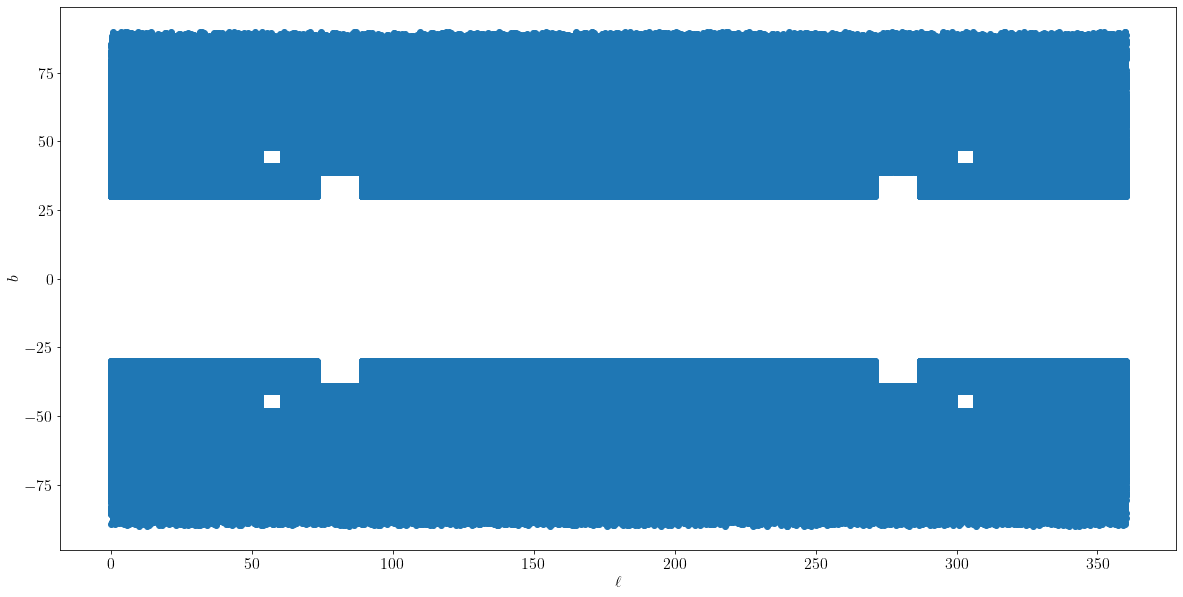

<Figure size 1440x720 with 0 Axes>

In [27]:
plt.rcParams["figure.figsize"] = (20,10);
plt.scatter(l,b);
plt.xlabel(r'$\ell$');
plt.ylabel(r'$b$');
plt.figure();

plt.hist(distances);

### Coordinate Transformations (Heliocentric -> LSR frame)
For each star, the astrometric parameters we require from Gaia are equatorial right ascension ($\alpha$) and declination ($\delta$), galactocentric longitude ($\ell$) and latitude ($b$), parallax ($\varpi$), equatorial proper motions ($\mu_\alpha^\ast$ and $\mu_\delta$), and radial velocity ($v_r$).

#### Galactic Proper Motions
There are standard angles $\alpha_G=192.85948^\circ$ and $\delta_G=27.12825^\circ$ that we consider when constructing the galactocentric coordinate system [7] -- these are the angular positions of the Galactic North Pole from Earth, to be precise. Furthermore, we quote the distance from the Earth to the galactic center (GC) as $R_0=8178\pm13_{stat.}\pm22_{sys.}\;pc$ [8]. To convert to proper motions along galactic $\ell$ and $b$:<br>
<h1><center>$C_1=\sin\delta_G\cos\delta-\cos\delta_G\sin\delta\cos(\alpha-\alpha_G)$<br>
$C_2=\cos\delta_G\sin(\alpha-\alpha_G)$<br>
$\mu_\ell=\frac{1}{\cos^2b}\left(C_1\mu_\alpha^\ast+C_2\mu_\delta\right)$<br>
$\mu_b=\frac{1}{\cos b}\left(C_1\mu_\delta-C_2\mu_\alpha^\ast\right)$<br></center></h1>


#### Galactocentric Velocities
Note that Gaia reports its angles in degrees, its parallaxes in mas, its proper motions in mas/yr, and its radial velocities in km/s.<br><br>
From the parallax angle, the distance in kpc is just<br>
<h1><center>$d=\frac{1}{\varpi}$<br></center></h1>
If we then convert the distances from kpc to km and the proper motions from mas/yr to rad/s, using the conversion factors in the cell above, future conversion steps are made a bit more convenient.<br><br>
Now, the physical velocities (in km/s) along $\ell$ and $b$ are<br>
<h1><center>$v_\ell=\mu_\ell d\cos b\;\;\;,\;\;\;v_b=\mu_b d$<br></center></h1>
Moreover, the galactocentric position coordinates $x$, $y$, and $z$ are found from $d$, $\ell$, and $b$ as
<h1><center>$x=d\cos \ell\cos b-R_0,\;\;\;y=d\sin\ell\cos b,\;\;\;z=d\sin b$<br></center></h1>
Along $x$, $y$, and $z$, respectively, the galactic velocities $U$, $V$, and $W$ are:
<h1><center>$U=v_r\cos\ell\cos b-v_\ell\sin\ell-v_b\cos\ell\sin b$<br>$V=v_r\sin\ell\cos b+v_\ell\cos\ell-v_b\sin\ell\sin b$<br>$W=v_r\sin b+v_b\cos b$<br></center></h1>

Below is a reference image for the orientations of the $U$, $V$, $W$ velocities:
<div>
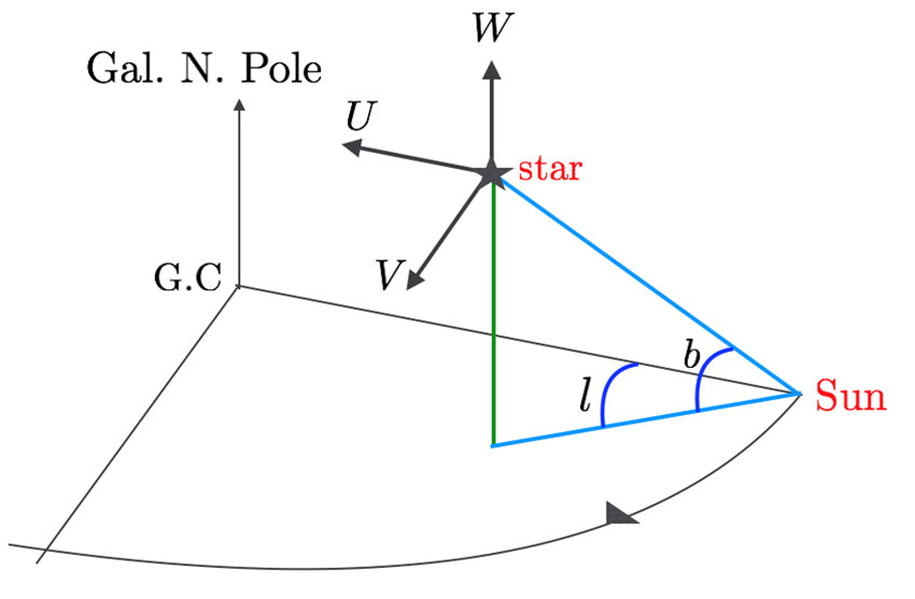
</div>
Diagram showing the orientation of the galactic velocities $U$, $V$, and $W$ with reference to the Sun and the GC.

#### LSR Frame
The Local Standard of Rest (LSR) is the rest frame of a star in a circular orbit about the GC at $R_0$. 
<br><br>
The main reason we want to work with quantities in the LSR frame is because the different Galactic components have distinct phase space signatures in the LSR velocities. From galactic velocities $U$, $V$, $W$, obtaining LSR velocities $U_{LSR}$, $V_{LSR}$, $W_{LSR}$ is just a simple spherical transformation.
<br><br>
But first, note that with respect to the LSR frame, propagating systematic/statistical errors, the Sun has an observed relative motion of $(U, V, W )_\odot = (11.1^{+1.21}_{−1.25}, 12.24^{+2.05}_{−2.05}, 7.25^{+0.62}_{−0.62})$ km/s [9]. The angles we rotate the galactic velocities through in our spherical transformation are calculated (via $x$, $y$, $z$) as
<h1><center>$\alpha=\arctan\left(-\frac{y}{x}\right)=\arctan\left(\frac{d\sin\ell \cos b}{R_0-d\cos\ell\cos b}\right)$<br>$\beta=\arctan\left(\frac{z}{\sqrt{y^2+x^2}}\right)=\arctan\left(\frac{d\sin b}{\sqrt{d^2\sin^2\ell\cos^2 b+(R_0-d\cos\ell\cos b)^2}}\right)$<br></center></h1>
Then,
<h1><center>$U_{LSR}=\cos\alpha\cos\beta(U+U_\odot)-\sin\alpha\cos\beta(V+V_\odot)-\sin\beta(W+W_\odot)$<br>$V_{LSR}=\sin\alpha(U+U_\odot)+\cos\alpha(V+V_\odot)$<br>$W_{LSR}=\cos\alpha\sin\beta(U+U_\odot)-\sin\alpha\sin\beta(V+V_\odot)+\cos\beta(W+W_\odot)$<br></center></h1>
<br><br>
7. R. Poleski, “Transformation of the equatorial proper motion to the Galactic
system,” arXiv e-prints, p. arXiv:1306.2945, 2013.<br>
8. The GRAVITY Collaboration, Abuter, R., Amorim, A., Baub ̈ock, M., et al.,
“A geometric distance measurement to the Galactic center black hole with 0.3%
uncertainty,” A&A, vol. 625, p. L10, 2019.<br>
9. R. Sch ̈onrich, J. Binney, and W. Dehnen, “Local kinematics and the local standard of rest,” Monthly Notices of the Royal Astronomical Society, vol. 403,
pp. 1829–1833, April 2010.

## Analysis/Results

*This is the bulk of the project - use statistical methods to analyze the data. This will require text to explain what you are doing (e.g., if you define a likelihood for the data, then you should write about how you arrived at that likelihood and write it out). The text should appear in markdown cells. This section will also present the software that executes the analysis, as well as any corresponding plots. Figures should have a caption (in a markdown cell). You will need multiple cells to complete this section* 

**NOTE: For data-based plots, I give both the code to generate the plots, and corresponding figures embedded in text showing what I obtained. In some cases, I've attached image files instead (because markdown is acting up). If the code does not cooperate/takes too long, please reference the embedded/attached figures.**<br><br>

### Kinematic Probability Method
What is referred to as the "kinematic probability" method revolves around deconvolving the Galactic components into distinct Gaussian velocity features in the LSR frame.<br><br>
Thus, each component is modeled by a Gaussian probability distribution function (pdf)
<h1><center>$f_i=\frac{1}{(2\pi)^{3/2}\sigma_U\sigma_V\sigma_W}\exp\left(-\frac{(U_{LSR}-U_{asym})^2}{2\sigma_U^2}-\frac{(V_{LSR}-V_{asym})^2}{2\sigma_V^2}-\frac{W_{LSR}^2}{2\sigma_W^2}\right)$<br></center></h1>
where $(\sigma_U , \sigma_V , \sigma_W )$ are the velocity dispersions and $(U_{asym}, V_{asym})$ are the mean velocity values unique to each component. It is assumed that $W_{LSR}$ averages around zero for each of the galactic components [10].<br><br>
The probabilities of a given star belonging to the particular Galactic components are found via<br>
<h1><center>$P_i=X_if_i$<br></center></h1>
where $X_i$ is the observed overall fraction of the component of
interest. For the thin disk, thick disk, and stellar halo, we denote the 3 probabilities
$D$, $TD$, and $H$ respectively.
<br><br> 
Prior studies with deconvolution algorithms (see Soubiran 2003 [11] for example) have deduced the overall population fractions, characteristic dispersions and velocity asymmetries of the different Galactic components. We use the particular values
summarized in Bensby et al. 2014 [10], which are tabulated below.<br>
<table style="width:70%">
<tr>
    <th> </th>
    <th>$\sigma_U$ (km/s)</th>
    <th>$\sigma_V$ (km/s)</th>
    <th>$\sigma_W$ (km/s)</th>
    <th>$U_{asym}$ (km/s)</th>
    <th>$V_{asym}$ (km/s)</th>
    <th>$X$</th> 
</tr>

<tr>
    <td>Thin Disk</td> 
    <td>35</td> 
    <td>20</td>
    <td>16</td> 
    <td>0</td> 
    <td>-15</td>
    <td>0.85</td>
</tr>

<tr>
    <td>Thick Disk</td> 
    <td>67</td> 
    <td>38</td> 
    <td>35</td>
    <td>0</td> 
    <td>-46</td> 
    <td>0.09</td> 
</tr>
    
<tr>
    <td>Halo</td> 
    <td>160</td> 
    <td>90</td> 
    <td>90</td>
    <td>0</td> 
    <td>-220</td> 
    <td>0.0015</td> 
</tr>

</table>
(Note that the local population fractions do not sum to 1, because Bensby et al. 2014 accounts for the proportion of stars in the Hercules stream, which make up the remaining 6% of their sample [10]. I have omitted the phase space data of the Hercules stream.)<br><br>
Aside: I have been working on my own Gaussian Mixture model to derive the Gaussian pdf parameters myself - to make the study more self-consistent and organic - but it still needs improvements before use. Therefore, I have made use of past studies.
<br><br>

### Contamination and Kinematic Criteria
Among kinematics, metallicity, and stellar age techniques for finding thin/thick disk and halo stars, there is a common issue of “contamination” of one galactic component into another, where the components overlap in phase space and stars in one component can be incorrectly labeled as belonging to another [12]. To mitigate component contamination, we define transition regions within which stars cannot be confidently assigned to a single population within a galactic component.<br><br>
To decide which population/transition region a star belongs to, we set inequality conditions on the probability ratios $TD/D$ and $TD/H$. The choice of cutoff in the inequalities is subjective – stricter cutoffs can be enforced to be increasingly certain of the galactic components. Generally, the inequality cutoffs have been chosen so that the probability of being in one population distribution is twice as likely as being in another distribution. The criteria chosen are:<br>
<h1><center>Thin Disk: $\frac{TD}{D}<0.5$</center></h1>
<h1><center>Thin/Thick Transition: $0.5<\frac{TD}{D}<2.0$</center></h1>
<h1><center>Thick Disk: $\frac{TD}{D}>2.0\;\;\&\;\;\frac{TD}{H}>2.0$</center></h1>
<h1><center>Thick/Halo Transition: $\frac{TD}{D}>2.0\;\;\&\;\;0.5<\frac{TD}{H}<2.0$</center></h1>
<h1><center>Stellar Halo: $\frac{TD}{D}>2.0\;\;\&\;\;\frac{TD}{H}<0.5$</center></h1>
Two conditions are enforced for the thick disk, halo, and thick disk/halo transition
regions as an additional measure for contamination from the thin disk. For example,
in identifying thick disk stars, one should check simultaneously that a particular star
is likely not a thin disk star ($TD/D$ condition) and not a halo star ($TD/H$ condition).<br><br>

### Population Variation and Sub-slicing in $z$
In the literature, techniques like the kinematic probability method have been used to characterize the number/fraction of stars in each component within a holistic stellar sample. To my knowledge of what I have seen published, nobody has applied this technique to look at how the component memberships (aka population fractions) are *distributed* throughout the Milky Way. I decided to study the vertical variation -- how the population fractions vary as one moves above or below the Milky Way mid-plane.<br><br>
Anticipating further study of how these fractions might be asymmetric North vs South of the mid-plane, I decided to slice my sample in $z$ symmetrically. 50 z-slices in the North, 50 z-slices in the South, with reflection symmetry in $z$ across the mid-plane. Recall from the query that our range in $z$ is $0.2<|z|<3.0$ kpc.<br><br>
The next step in the analysis is to take our overall stellar sample and group the stars into their appropriate z-slices. Then, within each slice, we calculate the number of stars in each Galactic component and derive population fraction values for the given z-slice. A choice of 50 z-slices in each hemi-sphere gives a reasonable balance in binning which yields both small–scale
structure and larger trends in the population fractions.

### Error Estimation via Bootstrapping
Gaia reports astrometric uncertainties for each star. One can follow all of the unit conversions and coordinate transformations described earlier to propagate uncertainties even up to the population fraction ratios. But a problem arises -- how do we calculate an error on the counts that result from our inequalities in the kinematic criteria? We cannot just take a Poisson error on the counts, because our sample has other sources of variance we should consider. But there is no straightforward way to propagate uncertainties in the population fraction ratios *through* the inequality conditions.<br><br>
Instead, the variation within our sample can be captured with bootstrapping. As an error estimation technique, bootstrapping involves taking a particular data set, randomly sampling from it while allowing for repetition of data points – as opposed to permutative sampling – and thereby generating a number of synthetic data sets, of the same size as the original set. Then, a quantity of interest from each synthetic data set is calculated, yielding an approximate ‘bootstrap distribution’ of
values from which a standard deviation can be drawn (see pages 3 & 4 in Efron 1979 [13]).
<br><br>
In context of this project, we seek an error assessment for the population fractions calculated for each z–slice of our sample. Stars in a given z–slice are re–sampled with repetition to generate 100 synthetic data sets. From each synthetic data set, we find the fraction (%) of each population, then the 100 sets of fractions are averaged (averaged among the synthetic data sets, not *within* each synthetic data set) and a standard deviation is drawn from them.<br><br>
(Note that moving away from the galactic mid–plane, there are increasingly less
stars per sub–slice, leading to worse bootstrap statistics and greater error bars.)
<br><br>

10. Bensby, T., Feltzing, S., and Oey, M. S., “Exploring the Milky Way stellar disk - A detailed elemental abundance study of 714 F and G dwarf stars in the solar
neighbourhood,” A&A, vol. 562, p. A71, 2014.
11. C. Soubiran, O. Bienaym ́e , and A. Siebert, “Vertical distribution of Galactic
disk stars,” A&A, vol. 398, pp. 141–151, January 2003.
12. A. Carrillo, K. Hawkins, B. P. Bowler, W. Cochran, and A. Vanderburg, “Know
thy star, know thy planet: chemo-kinematically characterizing TESS targets,”
Monthly Notices of the Royal Astronomical Society, vol. 491, pp. 4365–4381,
November 2019.
13. B. Efron, “Bootstrap Methods: Another Look at the Jackknife,” The Annals of
Statistics, vol. 7, no. 1, pp. 1 – 26, 1979.

### Kinematic Analysis Code
Below is the implementation for the described kinematic probability analysis. Stars are distributed into z-slices, the LSR velocities are calculated and a set of population fractions (with boostrap errors) are found for each slice. 
<br><br>
NOTE: To get the point across and save some computation time for this project, I reduced the number of synthetic data sets to 25 within the code -- If you decide to run this it will still likely take multiple hours. However, the plot I include in the Results section uses the full 100 synthetic data sets.

In [30]:
# Define a function for the full kinematic probability procedure
# Given a data set, returns the derived number of stars in each population

def KinematicProb(numstars, ra_dec_data, l, b, distances, rad_vel):
    
    alpha_g = 192.85948*(np.pi/180) # converted from degrees to radians
    delta_g = 27.12825*(np.pi/180) # converted from degrees to radians
    l_NGP = 122.93192*(np.pi/180) # converted from degrees to radians

    # All in km/s
    USun = 11.1
    VSun = 12.24
    WSun = 7.25

    # Thin Disk Params
    DSigU = 35
    DSigV = 20
    DSigW = 16
    DUAsym = 0
    DVAsym = -15
    DX = 0.85

    # Thick Disk Params
    TDSigU = 67
    TDSigV = 38
    TDSigW = 35
    TDUAsym = 0
    TDVAsym = -46
    TDX = 0.09

    # Halo Params
    HSigU = 160
    HSigV = 90
    HSigW = 90
    HUAsym = 0
    HVAsym = -220
    HX = 0.0015

    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    count5 = 0

    converted_pm = np.zeros([numstars,2], dtype = float)
    tangent_vels = np.zeros([numstars,2], dtype = float)
    x = np.zeros([numstars,1], dtype = float)
    y = np.zeros([numstars,1], dtype = float)
    z = np.zeros([numstars,1], dtype = float)

    alpha = np.zeros([numstars,1], dtype = float)
    beta = np.zeros([numstars,1], dtype = float)

    v_xyz = np.zeros([numstars,3], dtype = float)
    v_gal = np.zeros([numstars,3], dtype = float)

    for i in range(numstars):
        C1 = np.sin(delta_g)*np.cos(ra_dec_data[i,1]*(np.pi/180))-np.cos(delta_g)*np.sin(ra_dec_data[i,1]*(np.pi/180))*np.cos(ra_dec_data[i,0]*(np.pi/180)-alpha_g)
        C2 = np.cos(delta_g)*np.sin(ra_dec_data[i,0]*(np.pi/180)-alpha_g)

        cosb = np.sqrt(pow(C1,2)+pow(C2,2))

        converted_pm[i,0] = (C1*ra_dec_data[i,2]+C2*ra_dec_data[i,3])/pow(cosb,2)  # mu_l, in rad/s
        converted_pm[i,1] = (C1*ra_dec_data[i,3]-C2*ra_dec_data[i,2])/cosb         # mu_b, in rad/s

        tangent_vels[i,0] = converted_pm[i,0]*distances[i]*np.cos(b[i]*(np.pi/180))  # v_l, in km/s
        tangent_vels[i,1] = converted_pm[i,1]*distances[i]  # v_b, in km/s

        v_xyz[i,0] = rad_vel[i]*np.cos(l[i]*(np.pi/180))*np.cos(b[i]*(np.pi/180))-tangent_vels[i,0]*np.sin(l[i]*(np.pi/180))-tangent_vels[i,1]*np.cos(l[i]*(np.pi/180))*np.sin(b[i]*(np.pi/180))    # U, in km/s
        v_xyz[i,1] = rad_vel[i]*np.sin(l[i]*(np.pi/180))*np.cos(b[i]*(np.pi/180))+tangent_vels[i,0]*np.cos(l[i]*(np.pi/180))-tangent_vels[i,1]*np.sin(l[i]*(np.pi/180))*np.sin(b[i]*(np.pi/180))    # V, in km/s
        v_xyz[i,2] = rad_vel[i]*np.sin(b[i]*(np.pi/180))+tangent_vels[i,1]*np.cos(b[i]*(np.pi/180))                                                                                                 # W, in km/s

        x[i] = distances[i]*np.cos(b[i]*(np.pi/180))*np.cos(l[i]*(np.pi/180))-R0*3.08567758e16 # in km
        y[i] = distances[i]*np.cos(b[i]*(np.pi/180))*np.sin(l[i]*(np.pi/180))
        z[i] = distances[i]*np.sin(b[i]*(np.pi/180))

        alpha[i] = np.arctan2(y[i],-1*x[i])                             # in radians
        beta[i] = np.arctan2(z[i],np.sqrt(pow(y[i],2)+pow(x[i],2)))     # in radians

        if alpha[i] < 0: # if angle < 0, add 2pi
            alpha[i] += 2*np.pi

        if beta[i] < 0: # if angle < 0, add 2pi
            beta[i] += 2*np.pi

        ShiftedU = v_xyz[i,0]+USun
        ShiftedV = v_xyz[i,1]+VSun
        ShiftedW = v_xyz[i,2]+WSun

        v_gal[i,0] = np.cos(alpha[i])*np.cos(beta[i])*ShiftedU-np.sin(alpha[i])*np.cos(beta[i])*ShiftedV-np.sin(beta[i])*ShiftedW   # U_LSR, in km/s
        v_gal[i,1] = np.sin(alpha[i])*ShiftedU+np.cos(alpha[i])*ShiftedV                                                            # V_LSR, in km/s
        v_gal[i,2] = np.cos(alpha[i])*np.sin(beta[i])*ShiftedU-np.sin(alpha[i])*np.sin(beta[i])*ShiftedV+np.cos(beta[i])*ShiftedW   # W_LSR, in km/s

        probD = DX*(1/(pow(2*np.pi,1.5)*DSigU*DSigV*DSigW))*np.exp(-0.5*(pow((v_gal[i,0]-DUAsym)/DSigU,2)+pow((v_gal[i,1]-DVAsym)/DSigV,2)+pow(v_gal[i,2]/DSigW,2)))
        probTD = TDX*(1/(pow(2*np.pi,1.5)*TDSigU*TDSigV*TDSigW))*np.exp(-0.5*(pow((v_gal[i,0]-TDUAsym)/TDSigU,2)+pow((v_gal[i,1]-TDVAsym)/TDSigV,2)+pow(v_gal[i,2]/TDSigW,2)))
        probH = HX*(1/(pow(2*np.pi,1.5)*HSigU*HSigV*HSigW))*np.exp(-0.5*(pow((v_gal[i,0]-HUAsym)/HSigU,2)+pow((v_gal[i,1]-HVAsym)/HSigV,2)+pow(v_gal[i,2]/HSigW,2)))

        if probTD/probD > 2:
            if probTD/probH < 0.5: #Halo
                count1 += 1
            elif probTD/probH > 2: #Thick Disk
                count2 += 1
            elif 0.5 < probTD/probH < 2: # Thick/Halo Transition
                count3 += 1
        elif probTD/probD < 0.5: #Thin Disk
            count4 += 1
        elif 0.5 < probTD/probD < 2: #Thin/Thick Transition
            count5 +=1

    return [count1, count2, count3, count4, count5] # [Halo, Thick, Thick/Halo, Thin, Thin/Thick]

# South z-bounds
S_endabsz = -0.2*3.08567758e16 # in km
S_startabsz = -3.0*3.08567758e16 # in km

# North z-bounds
N_endabsz = 3.0*3.08567758e16 # in km
N_startabsz = 0.2*3.08567758e16 # in km

numslices = 50

S_zslices = np.linspace(S_startabsz, S_endabsz, num=numslices+1)
N_zslices = np.linspace(N_startabsz, N_endabsz, num=numslices+1)

N_dict = {}
S_dict = {}

for i in range(numslices):
    N_dict[i+1] = np.array([], dtype = np.uint32)
    S_dict[i+1] = np.array([], dtype = np.uint32)

for i in range(numstars):
    for j in range(numslices):
        if S_zslices[j] < distances[i]*np.sin(b[i]*(np.pi/180)) < S_zslices[j+1]:
            S_dict[j+1] = np.append(S_dict[j+1], i)
        if N_zslices[j] < distances[i]*np.sin(b[i]*(np.pi/180)) < N_zslices[j+1]:
            N_dict[j+1] = np.append(N_dict[j+1], i)

NameError: name 'random' is not defined

In [ ]:
num_synth = 25
            
N_countarr = []
N_errarr = []

S_countarr = []
S_errarr = []

for i in range(numslices):
    N_countarr.append(KinematicProb(len(N_dict[i+1]), np.take(ra_dec_data, N_dict[i+1], axis=0), np.take(l, N_dict[i+1], axis=0), np.take(b, N_dict[i+1], axis=0), np.take(distances, N_dict[i+1], axis=0), np.take(rad_vel, N_dict[i+1], axis=0)))
    S_countarr.append(KinematicProb(len(S_dict[i+1]), np.take(ra_dec_data, S_dict[i+1], axis=0), np.take(l, S_dict[i+1], axis=0), np.take(b, S_dict[i+1], axis=0), np.take(distances, S_dict[i+1], axis=0), np.take(rad_vel, S_dict[i+1], axis=0)))
    N_syncountarr = []
    S_syncountarr = []
    
    for j in range(num_synth):
        # Shuffle the array of indices I already have, with repetition
        N_ind = [random.choice(N_dict[i+1]) for x in range(len(N_dict[i+1]))]
        S_ind = [random.choice(S_dict[i+1]) for x in range(len(S_dict[i+1]))]
        N_syncountarr.append(KinematicProb(len(N_ind), np.take(ra_dec_data, N_ind, axis=0), np.take(l, N_ind, axis=0), np.take(b, N_ind, axis=0), np.take(distances, N_ind, axis=0), np.take(rad_vel, N_ind, axis=0)))
        S_syncountarr.append(KinematicProb(len(S_ind), np.take(ra_dec_data, S_ind, axis=0), np.take(l, S_ind, axis=0), np.take(b, S_ind, axis=0), np.take(distances, S_ind, axis=0), np.take(rad_vel, S_ind, axis=0)))
    
    N_syncountarr = np.array(N_syncountarr, dtype=float)
    S_syncountarr = np.array(S_syncountarr, dtype=float)
    N_fracvals = np.empty_like(N_syncountarr)
    S_fracvals = np.empty_like(S_syncountarr)

    for j in range(num_synth):
        N_fracvals[j] = 100*N_syncountarr[j]/np.sum(N_syncountarr[j])
        S_fracvals[j] = 100*S_syncountarr[j]/np.sum(S_syncountarr[j])

    N_errarr.append(np.std(N_fracvals, axis=0))
    S_errarr.append(np.std(S_fracvals, axis=0))

N_countarr = np.array(N_countarr, dtype=float)
S_countarr = np.array(S_countarr, dtype=float)
N_proparr = np.empty_like(N_countarr)
S_proparr = np.empty_like(S_countarr)

for i in range(numslices):
    N_proparr[i] = 100*N_countarr[i]/np.sum(N_countarr[i])
    S_proparr[i] = 100*S_countarr[i]/np.sum(S_countarr[i])

N_errarr = np.array(N_errarr, dtype=float)
S_errarr = np.array(S_errarr, dtype=float)

C:\Users\jthar\anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
### Plotting pop fracs
zslicesNtemp = np.linspace(N_startabsz, N_endabsz, num=numslices+1)
zslicesN = (zslicesNtemp[:-1] + np.diff(zslicesNtemp)/2)/3.08567758e16
zslicesStemp = np.linspace(S_startabsz, S_endabsz, num=numslices+1)
zslicesS = (zslicesStemp[:-1] + np.diff(zslicesStemp)/2)/3.08567758e16

for i in range(5):
    plt.errorbar(zslicesN, N_proparr[:,i], yerr=N_errarr[:,i], fmt='o', markersize=4) # North
    plt.errorbar(zslicesS, S_proparr[:,i], yerr=S_errarr[:,i], fmt='o', markersize=4) # South
    # plt.scatter(zslicesN, (N_proparr[:,i]-np.flip(dataS[:,i]))/(dataN[:,i]+np.flip(dataS[:,i])))

### Results
#### Population Fraction Distribution
Below are my plots of the population fraction distributions in $z$:
<div>
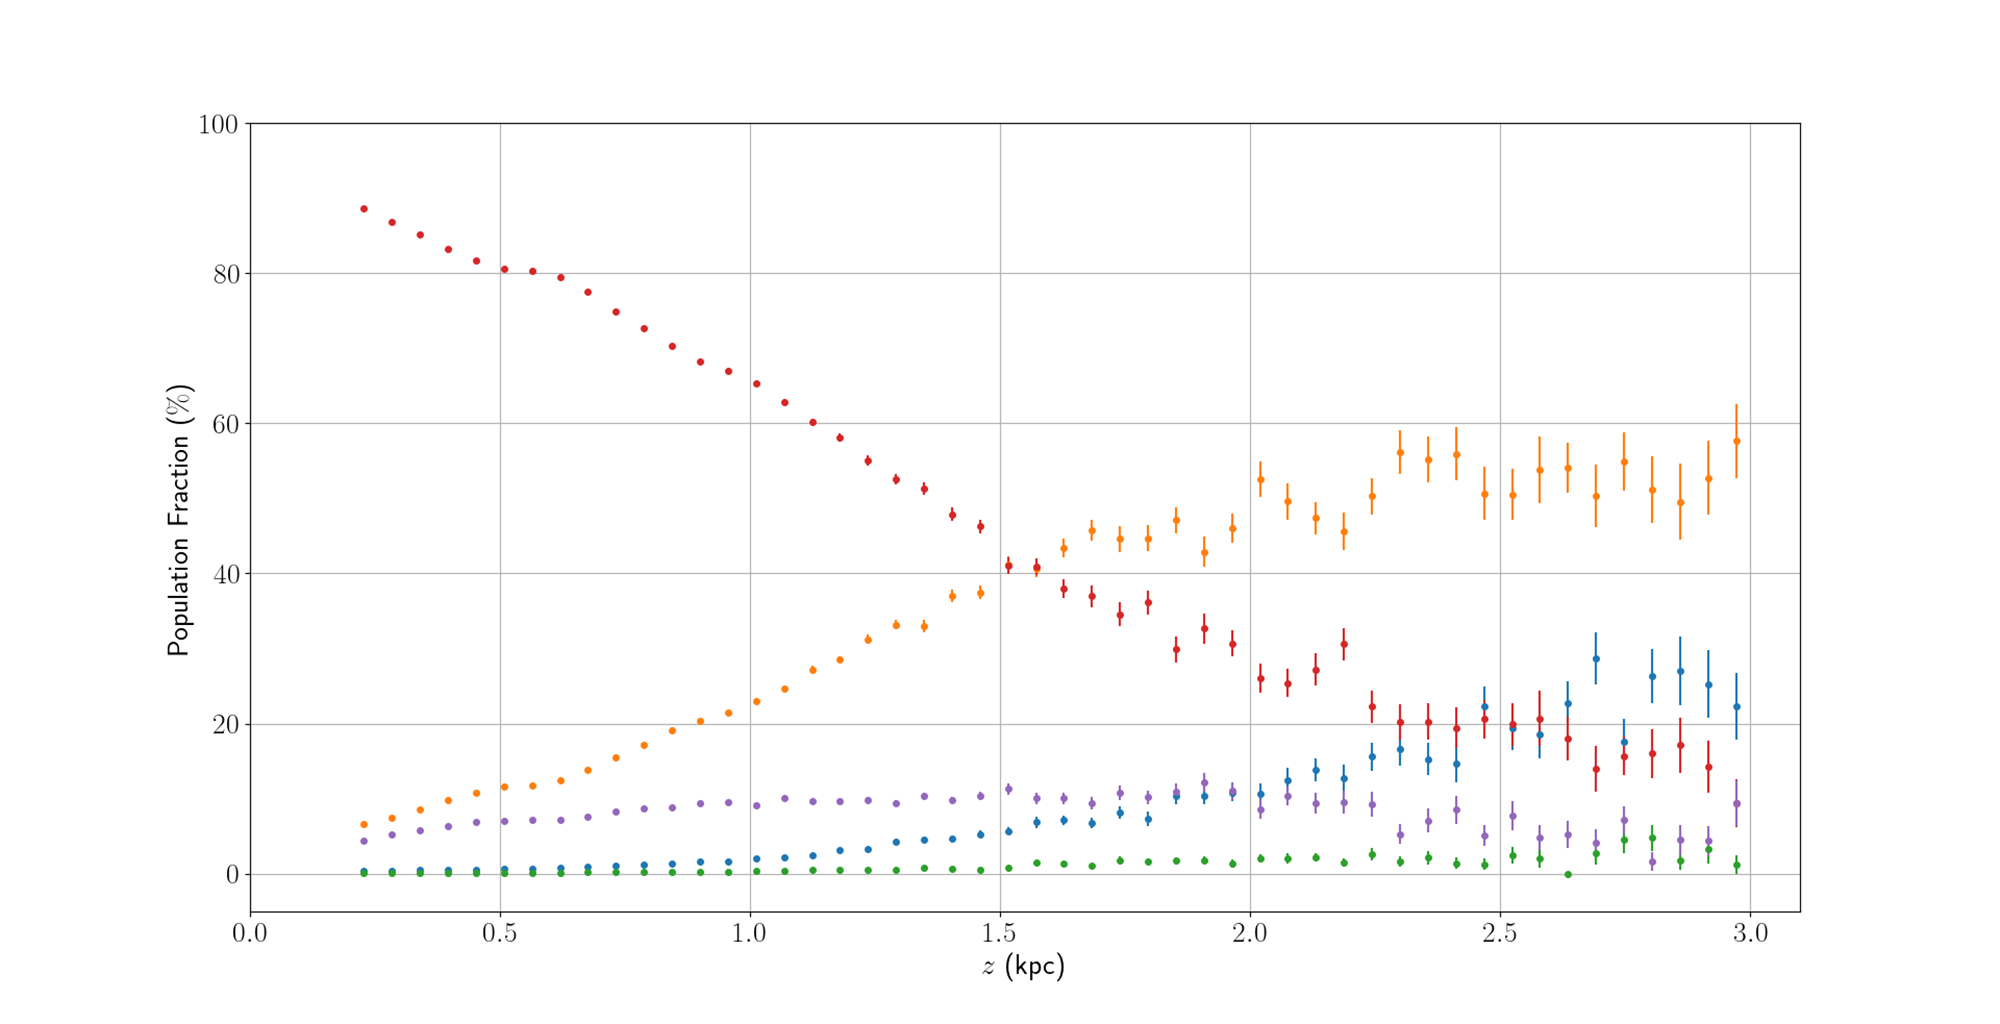
</div>
Scatter plot of population fraction (%) versus galactocentric $z$, for $z>0$ (North of the mid-plane). Red is the thin disk, orange is the thick disk, purple is the thin/thick transition, green is the thick/halo transition, and blue is the halo. 50 $z$-slices are taken, and 100 synthetic data sets are used to calculate the bootstrap errors for each slice.
<div>
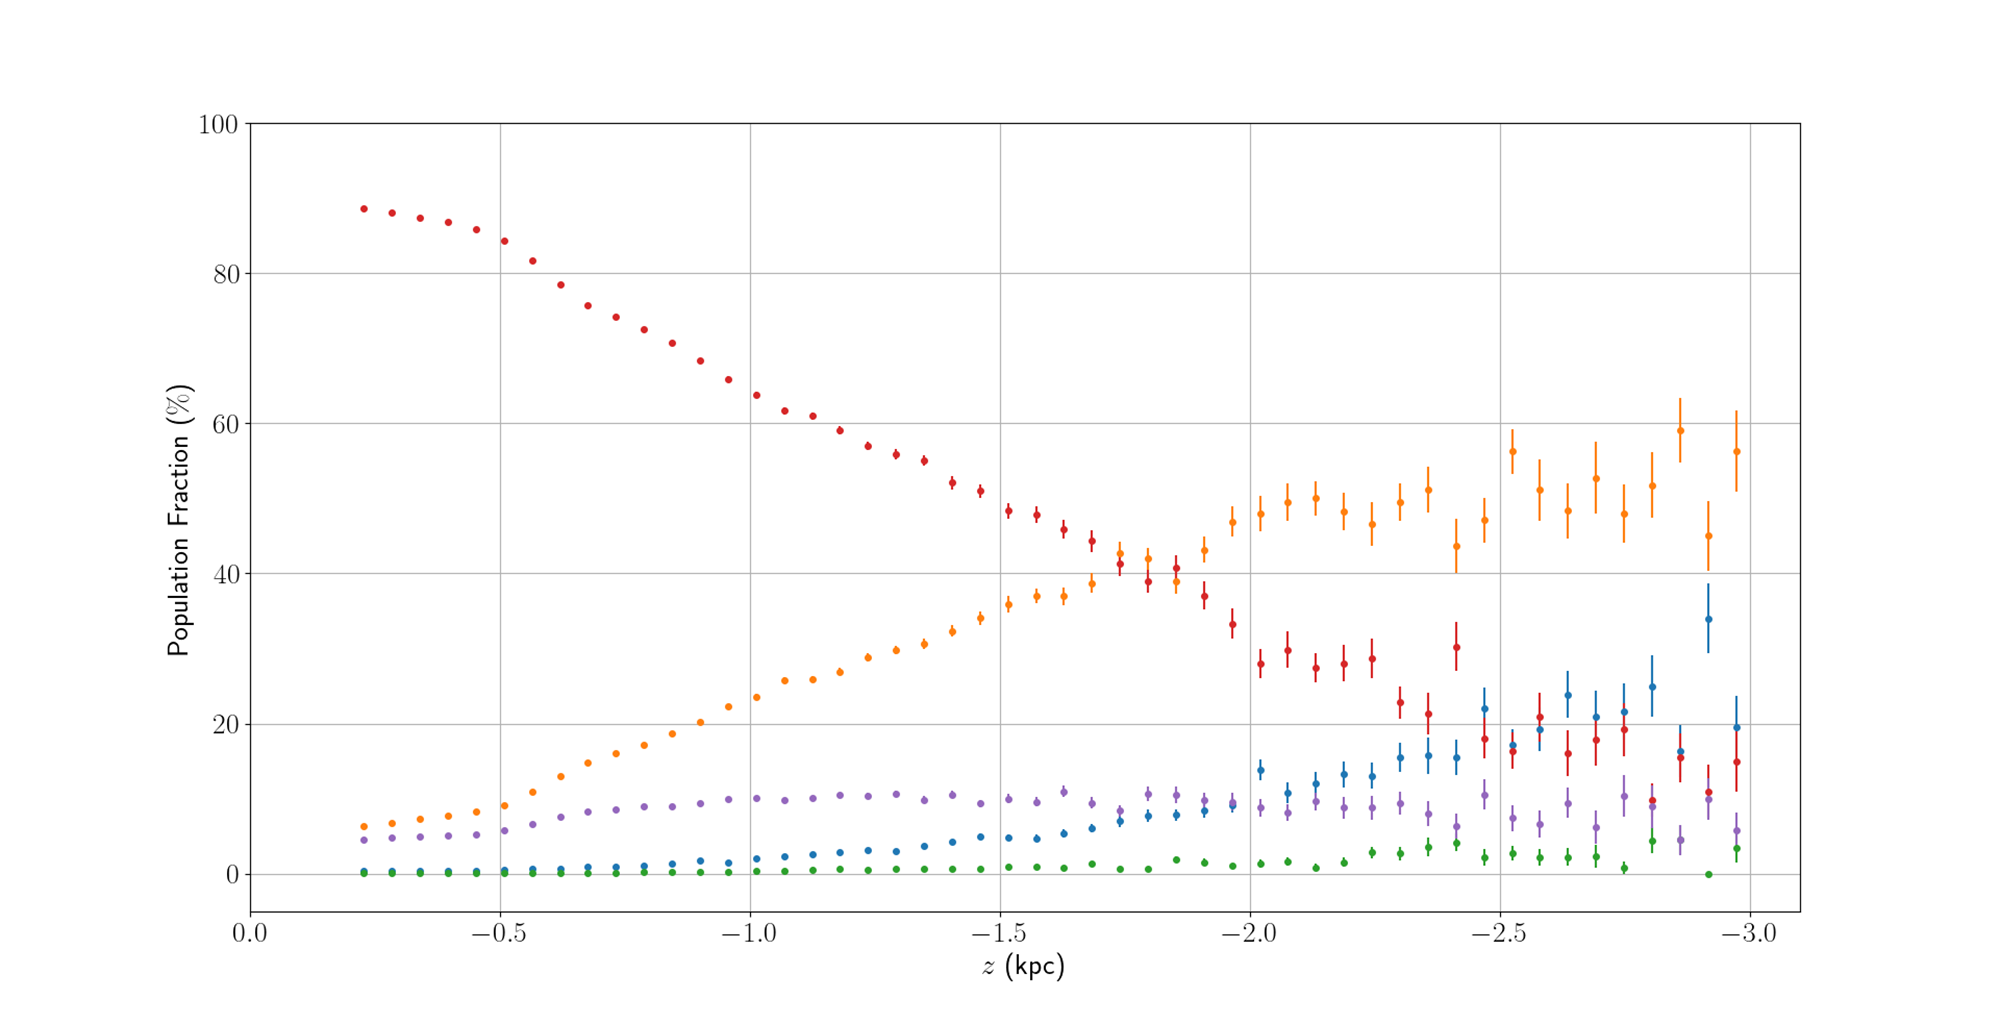
</div>
Scatter plot of population fraction (%) versus galactocentric $z$, for $z<0$ (South of the mid-plane). Red is the thin disk, orange is the thick disk, purple is the thin/thick transition, green is the thick/halo transition, and blue is the halo. 50 $z$-slices are taken, and 100 synthetic data sets are used to calculate the bootstrap errors for each slice.<br><br>
There are interesting qualitative features in these distributions to note.<br><br>Firstly, in the low-$z$ region, we see a plateau in the population fractions of the South compared to a steadier variation in the North. This behavior is interesting because the statistics of our sample are very good at low z, where the stars are the most concentrated, so this structure is very likely real.<br><br>
The other point of mention is the location where the thin disk and the thick disk have equal fraction -- what I call the "thin/thick crossover point." In the South, this occurs at about 1.768 kpc, compared to 1.544 kpc in the North. Taking a conservative error estimate in each of the crossover points as one $z$-slice width, the difference in the crossover points is $224\pm 79$ pc. On the scale of the Milky Way, this is a significant discrepancy.
<br><br>
Aside: This is not shown here, but compared to my plots for DR2, the bootstrap error bars have improved by roughly a factor of ~2 using the DR3 data.
<br><br>

#### Population Fraction Asymmetry
To quantify the North-South differences, we can define the asymmetry parameter
<h1><center>$\mathcal{A}\equiv \frac{f_i(z)-f_i(-z)}{f_i(z)+f_i(-z)}$</center></h1>
for a fraction $f$ of population $i$. Note that from the bootstrapped fraction errors, we can propagate the error in the asymmetry parameter as
<h1><center>$\sigma_\mathcal{A}=\frac{\sqrt{2\left[f_i^2(z)+f_i^2(-z)\right]\left[\sigma_{f_i(z)}^2+\sigma_{f_i(-z)}^2\right]}}{(f_i(z)+f_i(-z))^2}$</center></h1>
<br><br>
Calculating the asymmetry distribution for each the thin disk, thick disk, and stellar halo, the results are summarized below.
<div>
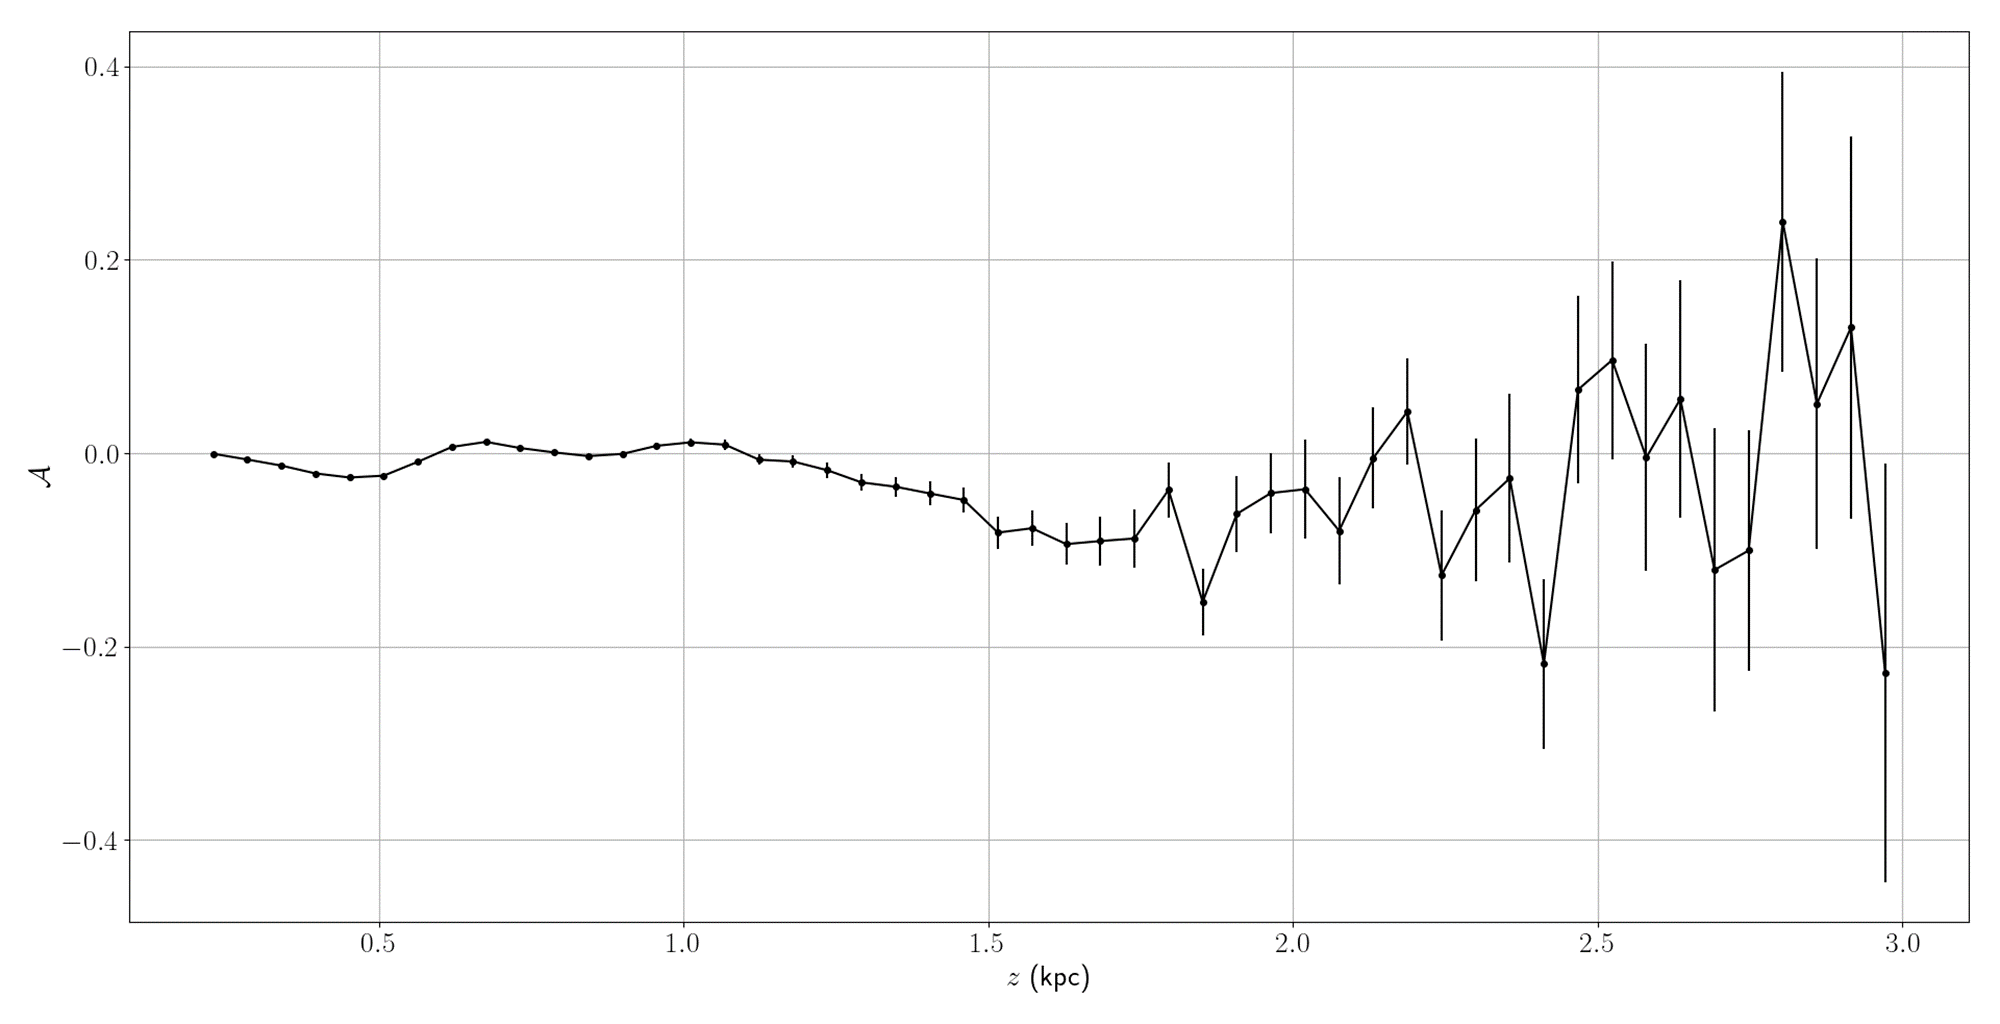
</div>
Asymmetry in the thin disk population fraction as a function of $z$. There is a relatively wide-$z$ overdensity of thin disk stars in the South at low $z$, close to the mid-plane. This fades into a sort of wave structure in the asymmetry at higher $z$. The thin disk has great statistics thanks to its relative abundance of stars.
<div>
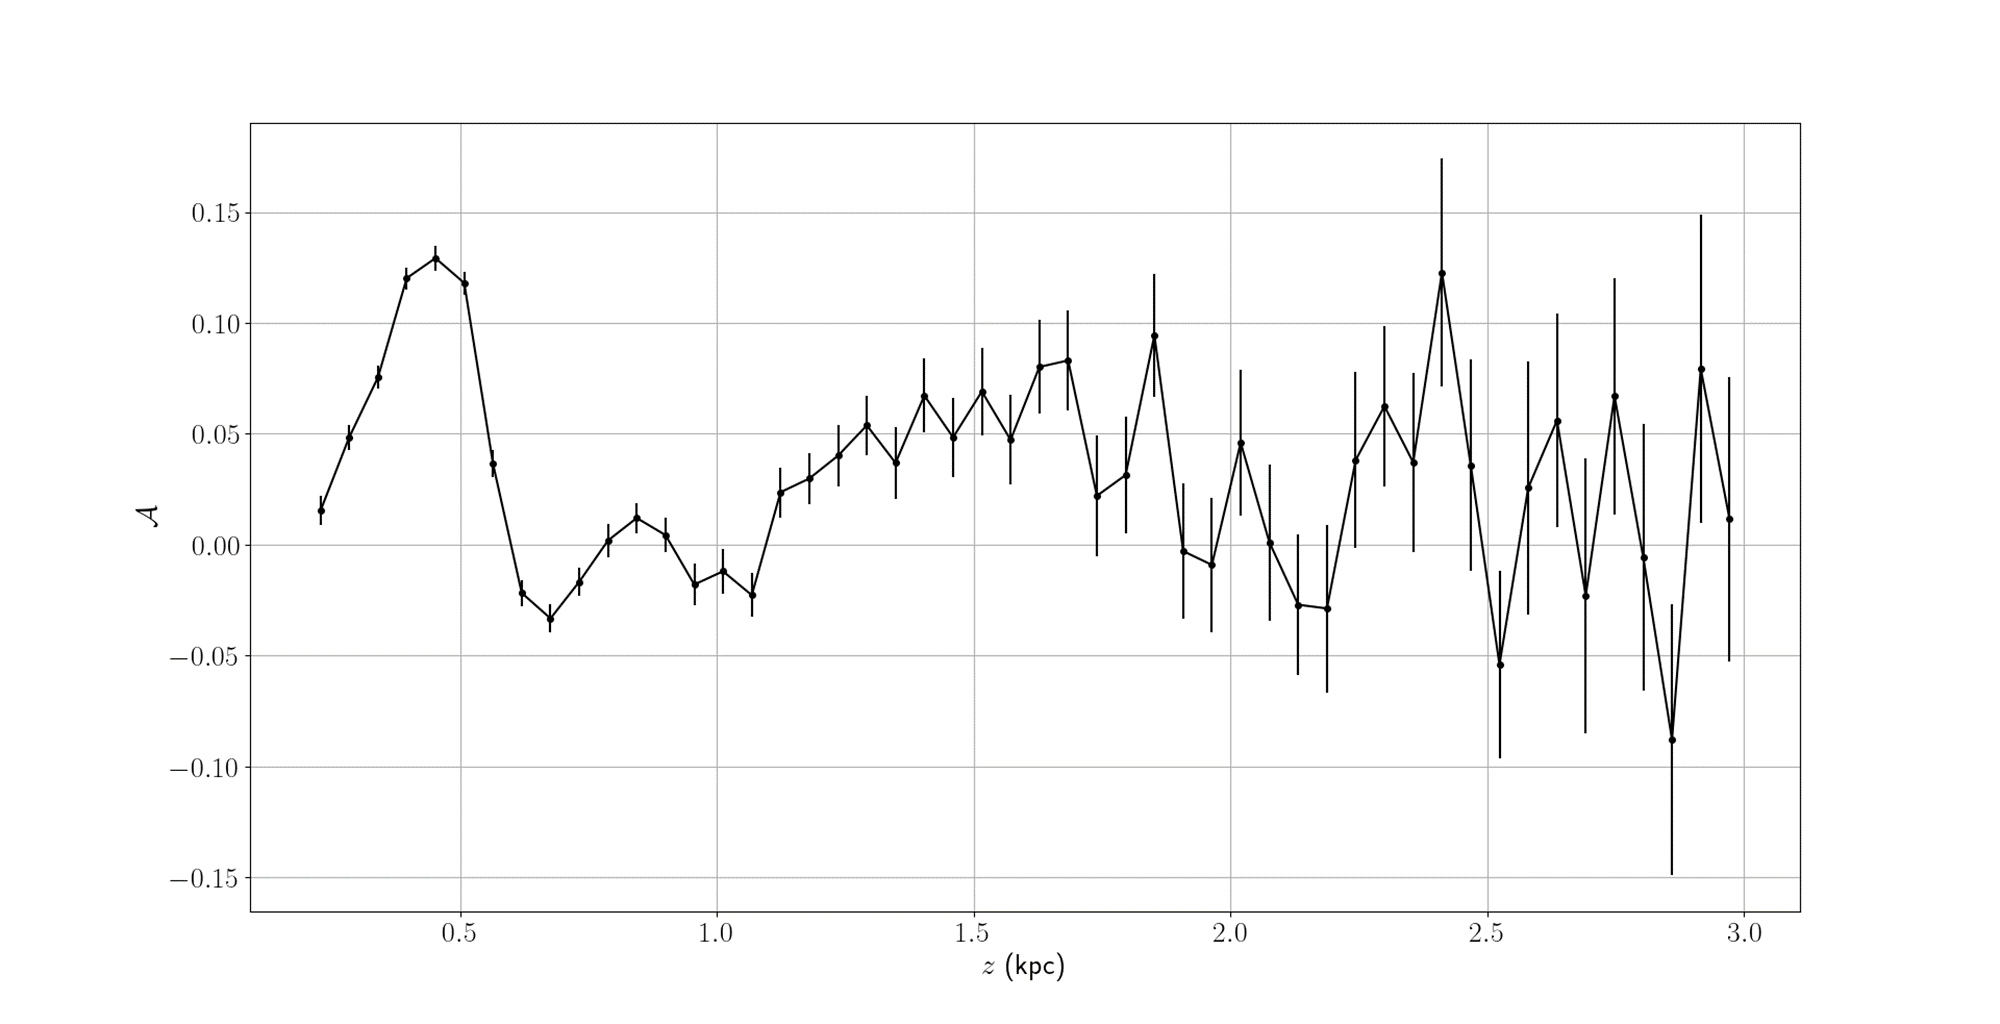
</div>
Asymmetry in the thick disk population fraction as a function of $z$. There is an overdensity of thick disk stars in the North at low $z$.
<div>
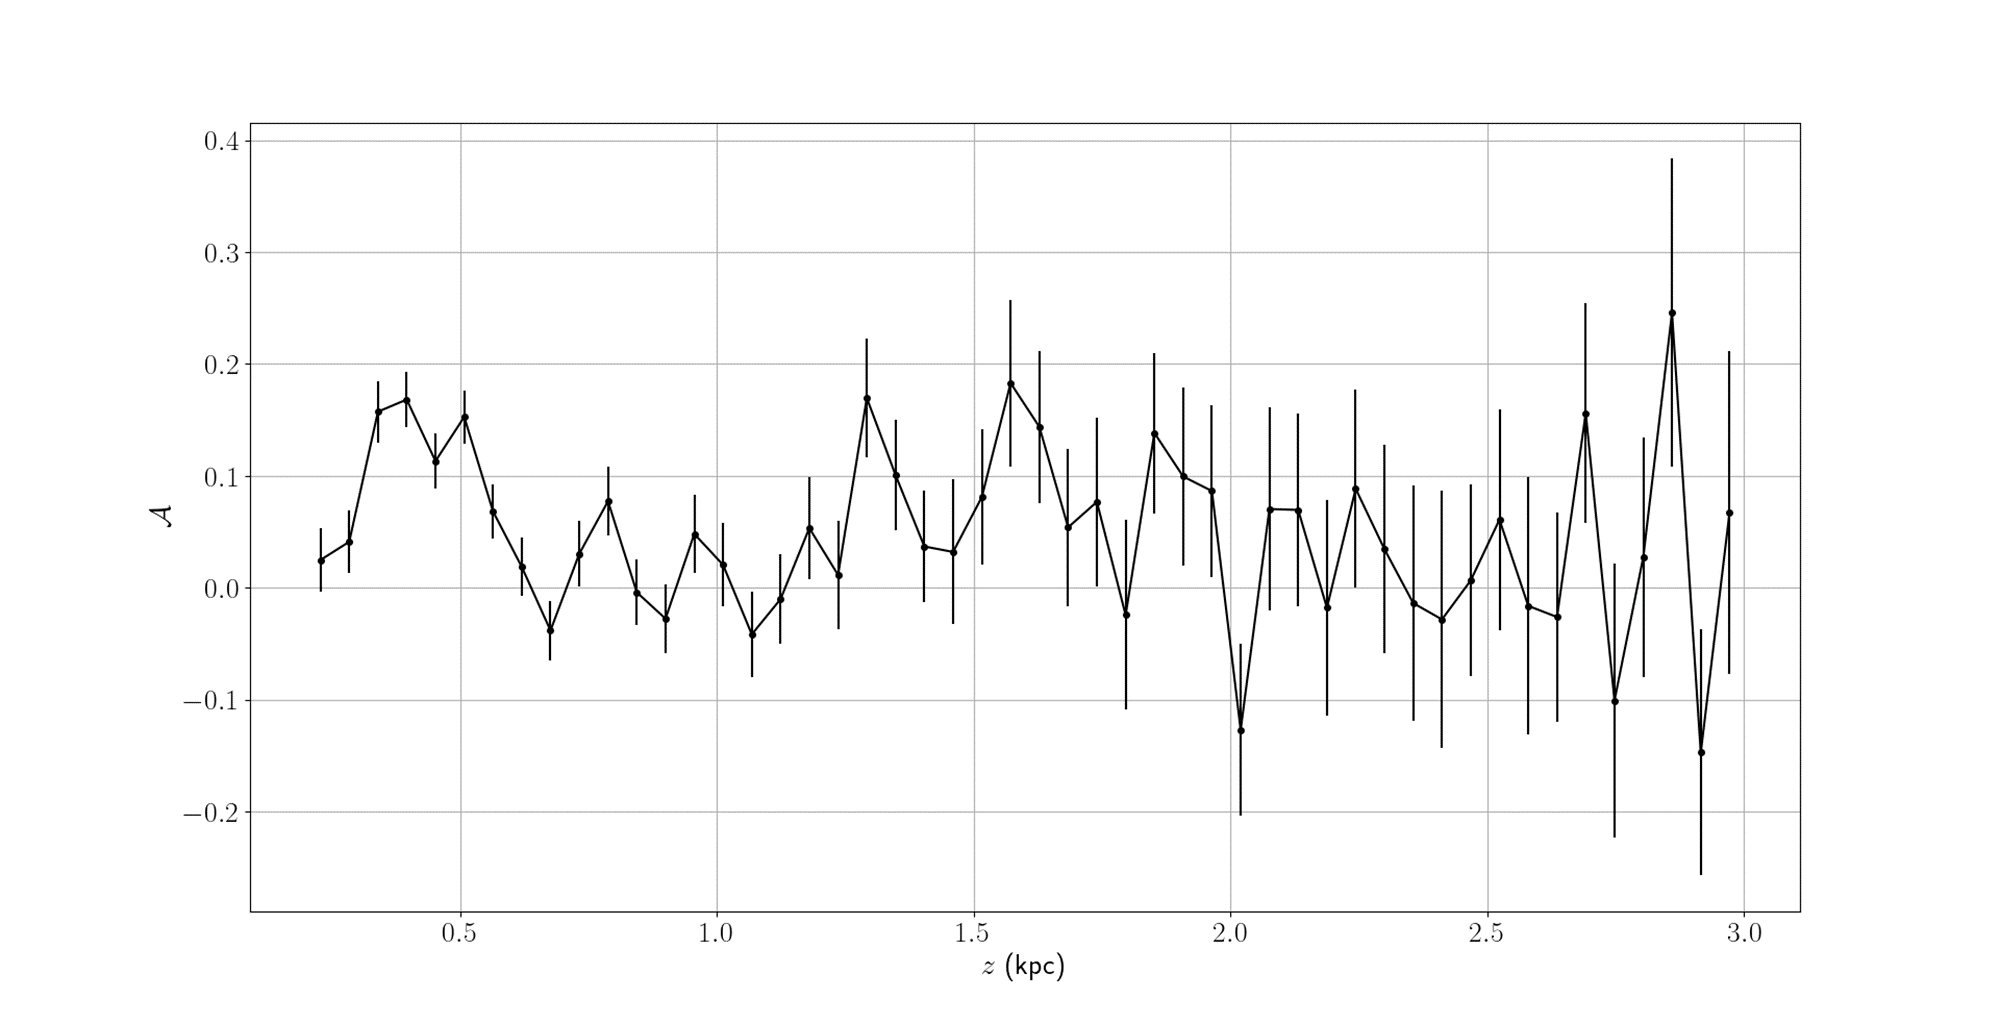
</div>

Asymmetry in the stellar halo population fraction as a function of $z$. Generally follows the same trends as the thick disk, but the error bars are larger, so any conclusions could be misleading.
<br><br>

#### Literature Comparison

Prior work has been done looking at the vertical distribution of stellar number density in the Milky Way and analogous asymmetry distributions. Below is a plot from Bennett & Bovy 2018 showing the number density asymmetry as a function of galactic $z$ [14].
<div>
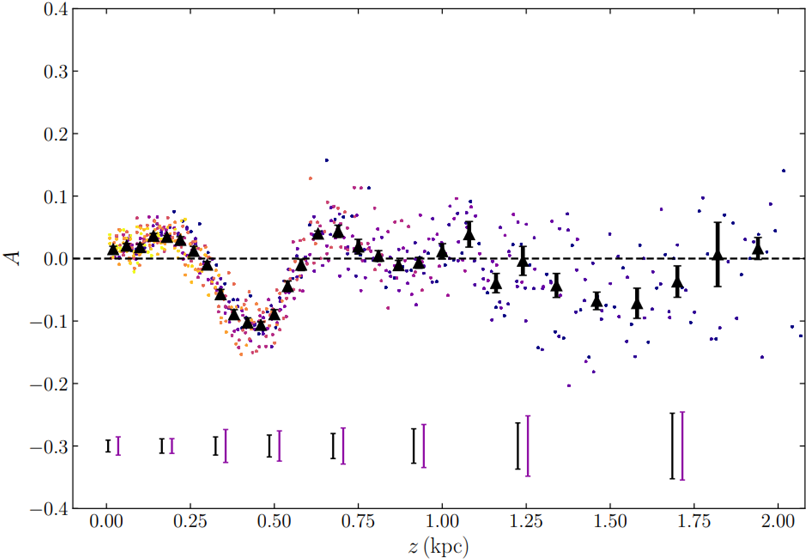
</div>
Distribution of number density asymmetry parameter vs galactic $z$. The black triangles represent the median asymmetry values for different $z$ bins.<br><br>
Take a close look at our thin disk asymmetry distribution and compare -- the peaks and troughs, especially at low $z$, fall on the same locations! Keep in mind that the number density plot extends down to $z=0$ kpc, while we have constrained ourselves to $0.2<|z|<3.0$ kpc. To see the similarities clearer, below is another plot of the thin disk asymmetry, this time zoomed to an upper bound just above 2 kpc.
<div>
<img src="attachment:image-2.png" width="750"/>
</div>
Zoomed-in region of the prior thin disk asymmetry distribution vs $z$.
<br><br><br>

#### Some Interpretations

What this implies, from a qualitative standpoint, is that the population fraction distribution in the thin disk (which forms the majority of our stellar sample) probes the same asymmetry effects as number density. Both number density and population fractions share the benefit of being relatively simple to calculate -- useful for large data sets like Gaia's.<br><br>
Number density and population fractions suffer from the weakness of being 1-body quantities, however. Techniques like 2-point correlation functions can probe non-steady state structure in the Milky Way with much finer detail, especially at high $z$ where the number of measured stars is low.<br><br>
The single thing that makes this work truly significant is the distinction of structure in the different galactic components, allowing new insight into (thick disk and stellar halo) structure that techniques like number density or 2-point correlation functions are not very sensitive too, as the thin disk makes up the majority of stars in studied samples, in many cases.
<br><br>

14. Morgan Bennett and Jo Bovy, “Vertical waves in the solar neighbourhood in Gaia
DR2,” Monthly Notices of the Royal Astronomical Society, vol. 482, pp. 1417–
1425, October 2018.

In [ ]:
### Code for calculating/plotting population frac asymmetries
NorthThin = N_proparr[:,3]
SouthThin = np.flip(S_proparr[:,3])
A_thin = (NorthThin-SouthThin)/(NorthThin+SouthThin)
A_thin_error = np.sqrt(2*(np.power(NorthThin,2)+np.power(SouthThin,2))*(np.power(N_errarr[:,3],2)+np.power(np.flip(S_errarr[:,3]),2)))/np.power(NorthThin+SouthThin,2)

NorthThick = N_proparr[:,1]
SouthThick = np.flip(S_proparr[:,1])
A_thick = (NorthThick-SouthThick)/(NorthThick+SouthThick)
A_thick_error = np.sqrt(2*(np.power(NorthThick,2)+np.power(SouthThick,2))*(np.power(N_errarr[:,1],2)+np.power(np.flip(S_errarr[:,1]),2)))/np.power(NorthThick+SouthThick,2)

NorthHalo = N_proparr[:,0]
SouthHalo = np.flip(S_proparr[:,0])
A_halo = (NorthHalo-SouthHalo)/(NorthHalo+SouthHalo)
A_halo_error = np.sqrt(2*(np.power(NorthHalo,2)+np.power(SouthHalo,2))*(np.power(N_errarr[:,0],2)+np.power(np.flip(S_errarr[:,0]),2)))/np.power(NorthHalo+SouthHalo,2)


plt.errorbar(zslicesN, A_thin, yerr=A_thin_error, fmt='o', markersize=4, color='black')
plt.plot(zslicesN, A_thin, color='black')

plt.errorbar(zslicesN, A_thick, yerr=A_thick_error, fmt='o', markersize=4, color='black')
plt.plot(zslicesN, A_thick, color='black')

plt.errorbar(zslicesN, A_halo, yerr=A_halo_error, fmt='o', markersize=4, color='black')
plt.plot(zslicesN, A_halo, color='black')

## Conclusions

*Write a few sentences summarizing the big take away from your analysis (e.g., I attempted to fit observations to measure the mass of an electron and I found $m_e = MMM.MMM \pm 0.MMM\,\mathrm{MeV}$...)*<br><br>
Qualitative results rather than quantitative
Because my results are distributions rather than single outcomes, the interpretations/conclusions drawn are more qualitative than quantitative.<br><br>
By Noether’s theorem, asymmetries in the Milky Way should arise by non-steady state effects. Distributions of the Milky Way component memberships show asymmetry in galactic z, closely mirroring the structure of ordinary number density in the case of the thin disk. This acts as reinforcement to the evidence of such non-steady state effects. Moreover, this population fraction study offers a novel way to probe interesting structure in the thick disk and stellar halo that most techniques are unable to access.